In [66]:
#Simple nu-O event generator for 10s-of-MeV neutrinos
#Follows approach taken by NEWTON
#
#Steps:
# Supply total xs (different choices), interpolate
# Supply partial xs, fit coefficients, interpolate
# Specify neutrino flux, fold with XS, sample
# Choose excitation
# Calculate lepton energy, direction, nuclear recoil
# Draw from pre-computed TALYS de-excitation files to generate events
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #Just for printing table of coefficients nicely
from matplotlib.colors import LogNorm

interpolationStep_MeV = 0.1 #Interpolate digitized plots with this precision
maxEnergy_MeV = 53
energies_MeV_interp = np.arange(0,maxEnergy_MeV,interpolationStep_MeV)

#total_xs_name = "data/total_xs/Haxton1987.csv"
total_xs_name = "data/total_xs/Haxton1987_NEWTON.csv"

partial_xs_name = "data/partial_xs/Nakazato2018.csv"
outputFormat = "ascii" #root, ascii

nps = 1000

#############
##Constants##
#############
#AME 20 mass evaluations: https://www.anl.gov/sites/www/files/2021-05/mass_1.mas20.txt
mass_16O_amu = 15994914.61926e-6 #includes 8 electrons
mass_16F_amu = 16011460.278e-6 #includes 9 electrons
amu_to_MeV = 931.49432
me_MeV = 0.51099895069
m_mu_amu = 113428.9267e-6
m_mu_MeV = m_mu_amu* amu_to_MeV

#(160 + 8 electrons) + nu_e -> (16F + 8 electrons) + 1 electron 
threshold = (mass_16F_amu-mass_16O_amu)*amu_to_MeV
print(f"Threshold of 16O CC process is {threshold:.3f} MeV")

Threshold of 16O CC process is 15.412 MeV


/var/folders/1n/bs1qz7t54lb6q7c55xmy1lnr0000gn/T/ipykernel_1414/3193689142.py:22: RuntimeWarning: divide by zero encountered in log10
  logxs_cm2_raw = np.log10(xs_cm2_raw)


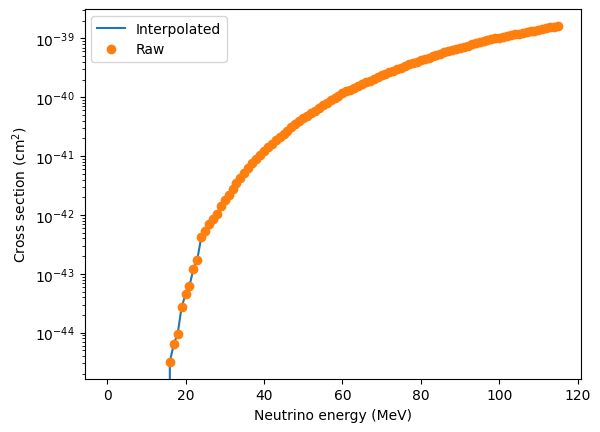

In [67]:
#################
##Load total XS##
#################
def loadCSV(fname):
  energies_MeV_raw = []
  xs_cm2_raw = []
  for line in open(fname,"r"):
    if not line.startswith("#"):
      line=line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        if len(lineParts)==2:
          energies_MeV_raw.append(float(lineParts[0]))
          xs_cm2_raw.append(float(lineParts[1]))
  

  return energies_MeV_raw,xs_cm2_raw

energies_MeV_raw,xs_cm2_raw = loadCSV(total_xs_name)

#Log-linear inteerpolation
logxs_cm2_raw = np.log10(xs_cm2_raw)
logxs_interp = np.interp(energies_MeV_interp, energies_MeV_raw, logxs_cm2_raw,left=-np.inf,right=logxs_cm2_raw[-1])
xs_cm2_interp = np.power(10,logxs_interp)

#Linear interpolation
#xs_cm2_interp = np.interp(energies_MeV_interp,energies_MeV_raw,xs_cm2_raw,left=0,right=xs_cm2_raw[-1])

########
##Plot##
########
plt.plot(energies_MeV_interp,xs_cm2_interp,label="Interpolated")
plt.plot(energies_MeV_raw,xs_cm2_raw,ls="",marker="o",label="Raw")
plt.legend()
plt.xlabel("Neutrino energy (MeV)")
plt.ylabel("Cross section (cm$^2$)")
plt.yscale("log")


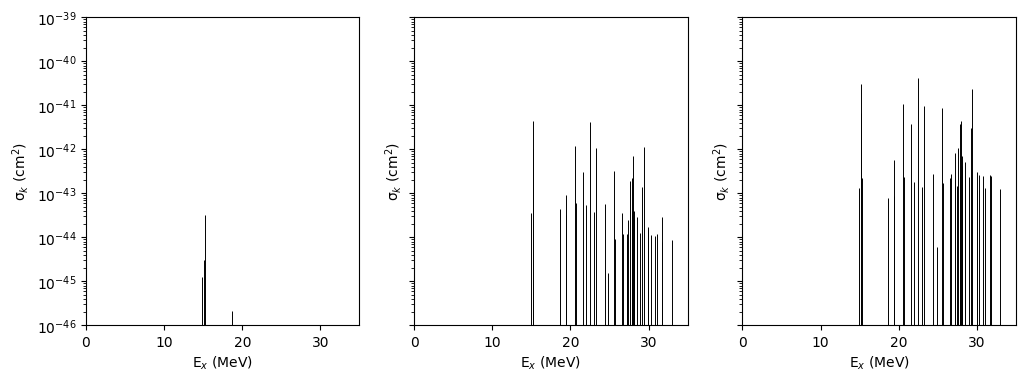

,Excited level (MeV),J,parity,20 MeV,40 MeV,60 MeV
0,14.91,0,-,1.280000e-45,3.540000e-44,1.320000e-43
1,15.16,1,-,3.100000e-45,9.960000e-43,6.810000e-42
2,15.21,2,-,3.160000e-44,4.380000e-42,3.050000e-41
3,15.25,3,-,1.000000e-46,3.800000e-45,2.250000e-43
4,18.67,1,+,2.150000e-46,4.370000e-44,8.030000e-44
5,19.42,2,-,1.000000e-47,9.180000e-44,5.820000e-43
6,19.43,1,+,1.000000e-47,3.220000e-44,8.650000e-44
7,20.57,1,-,0.000000e+00,1.220000e-42,1.090000e-41
8,20.69,1,+,0.000000e+00,5.990000e-44,2.350000e-43
9,21.62,2,-,0.000000e+00,3.040000e-43,3.700000e-42


In [68]:
#Load partial cross sections
def loadNazakatoData(fname):
  excitedLevels_MeV = []
  excitedLevels_J = []
  excitedLevels_parity = []
  excitedXS_20MeV = []
  excitedXS_40MeV = []
  excitedXS_60MeV = []
  for line in open(fname,"r"):
    if not line.startswith("#"):
      line=line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        if len(lineParts)==6:
          excitedLevels_MeV.append(float(lineParts[0]))
          excitedLevels_J.append(int(lineParts[1]))
          if lineParts[2]=="1":
            parity = "-"
          else:
            parity = "+"
          excitedLevels_parity.append(parity)
          excitedXS_20MeV.append(float(lineParts[3]))
          excitedXS_40MeV.append(float(lineParts[4]))
          excitedXS_60MeV.append(float(lineParts[5]))
  
  #FIT COEFFICIENTS
  excitedLevels_MeV = np.asarray(excitedLevels_MeV)
  excitedXS_20MeV = np.asarray(excitedXS_20MeV)
  excitedXS_40MeV = np.asarray(excitedXS_40MeV)
  excitedXS_60MeV = np.asarray(excitedXS_60MeV)

  return excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV
  
excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV = loadNazakatoData(partial_xs_name)

#Make 3 plots of xs vs. excitation energy 
fig,ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

mask = excitedXS_20MeV > 0
ax[0].vlines(excitedLevels_MeV[mask], 1e-46, excitedXS_20MeV[mask],color="k",lw=0.7)
mask = excitedXS_40MeV > 0
ax[1].vlines(excitedLevels_MeV[mask], 1e-46, excitedXS_40MeV[mask],color="k",lw=0.7)
mask = excitedXS_60MeV > 0
ax[2].vlines(excitedLevels_MeV[mask], 1e-46, excitedXS_60MeV[mask],color="k",lw=0.7)

plt.yscale("log")
ax[0].set_xlim(0,35)
ax[0].set_xlabel("E$_x$ (MeV)")
ax[0].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[0].set_ylim(1e-46,1e-39)

ax[1].set_xlim(0,35)
ax[1].set_xlabel("E$_x$ (MeV)")
ax[1].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[1].set_ylim(1e-46,1e-39)

ax[2].set_xlim(0,35)
ax[2].set_xlabel("E$_x$ (MeV)")
ax[2].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[2].set_ylim(1e-46,1e-39)
plt.show()


df = pd.DataFrame({
    "Excited level (MeV)": excitedLevels_MeV,
    "J": excitedLevels_J,
    "parity": excitedLevels_parity,
    "20 MeV": excitedXS_20MeV,
    "40 MeV": excitedXS_40MeV,
    "60 MeV": excitedXS_60MeV,
})

df

In [69]:
#Solve for coefficients
def solveCoeffs(excitedLevels_MeV,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV):
  c1s = []
  c2s = []
  c3s = []
  #Now step through levels, computing nu xs by fitting the three data files to determine coefficients a,b,c. Then
  for ilev,Ex in enumerate(excitedLevels_MeV):

    if Ex < 20:
      Lambda_20MeV = np.log10(np.power(20,0.25)-np.power(Ex,0.25))
    else:
      Lambda_20MeV = 0
    if Ex < 40:
      Lambda_40MeV = np.log10(np.power(40,0.25)-np.power(Ex,0.25))
    else:
      Lambda_40MeV = 0
    if Ex < 60:
      Lambda_60MeV = np.log10(np.power(60,0.25)-np.power(Ex,0.25))
    else:
      Lambda_60MeV = 0

    if excitedXS_20MeV[ilev]>1e-46:
      logxs_20MeV = np.log10(excitedXS_20MeV[ilev])
    else:
      logxs_20MeV =  -np.inf
    if excitedXS_40MeV[ilev]>0:
      logxs_40MeV = np.log10(excitedXS_40MeV[ilev])
    else:
      logxs_40MeV = -np.inf
    if excitedXS_60MeV[ilev]>0:
      logxs_60MeV = np.log10(excitedXS_60MeV[ilev])
    else:
      logxs_60MeV = -np.inf

    if logxs_20MeV==-np.inf:
      A = np.array([[1.0,Lambda_40MeV],
                  [1.0,Lambda_60MeV]])
      y = np.array([logxs_40MeV,logxs_60MeV])
      a,b = np.linalg.solve(A,y)
      c = 0
    else:
      A = np.array([[1.0,Lambda_20MeV,Lambda_20MeV*Lambda_20MeV],
                  [1.0,Lambda_40MeV,Lambda_40MeV*Lambda_40MeV],
                  [1.0,Lambda_60MeV,Lambda_60MeV*Lambda_60MeV]])
      y = np.array([logxs_20MeV,logxs_40MeV,logxs_60MeV])
      a,b,c = np.linalg.solve(A,y)

    c1s.append(a)
    c2s.append(b)
    c3s.append(c)

  return c1s,c2s,c3s
  
c1s,c2s,c3s = solveCoeffs(excitedLevels_MeV,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV)

df = pd.DataFrame({
    "Excited level (MeV)": excitedLevels_MeV,
    "a": c1s,
    "b": c2s,
    "c": c3s,
})

df
      


,Excited level (MeV),a,b,c
0,14.91,-42.567378,3.669191,1.030182
1,15.16,-40.714086,5.003411,0.629842
2,15.21,-40.033353,5.359914,1.523212
3,15.25,-41.707498,10.098327,0.000000
4,18.67,-42.938851,0.926599,-0.668530
5,19.42,-41.623240,3.708173,0.000000
6,19.43,-42.735442,1.983075,0.000000
7,20.57,-40.197107,4.143248,0.000000
8,20.69,-42.148820,2.569987,0.000000
9,21.62,-40.524354,4.473532,0.000000


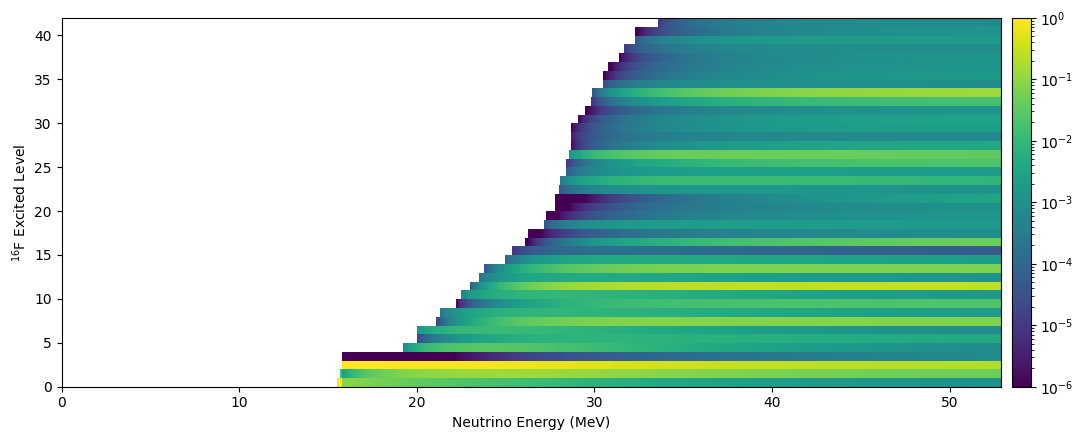

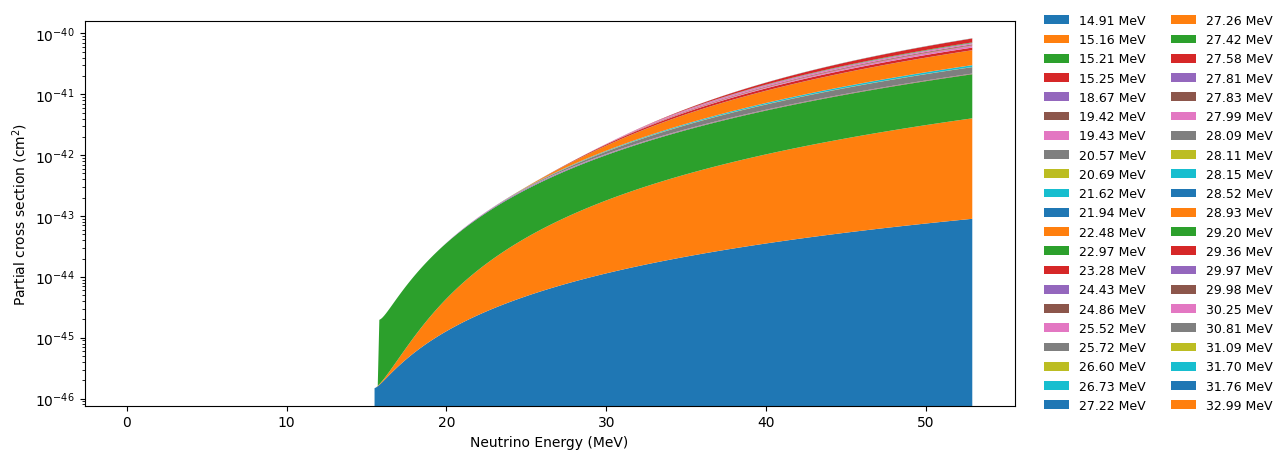

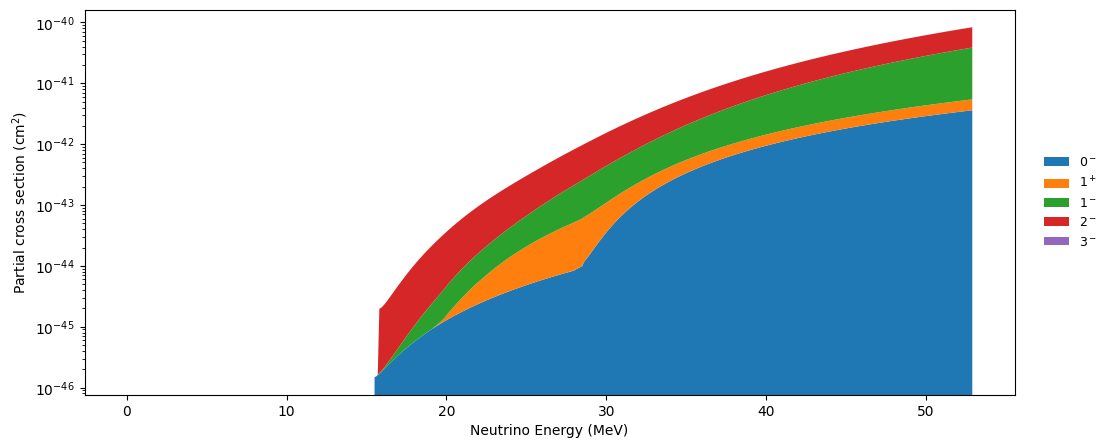

In [70]:
#Now calculate partial_xs
eps_MeV = 0.0

partial_xs = []
for ilev,Ex_MeV in enumerate(excitedLevels_MeV):
  xs = np.zeros_like(energies_MeV_interp)
  if c3s[ilev]==0:
    for inrg,E in enumerate(energies_MeV_interp):
      if E<=Ex_MeV + me_MeV:
        continue
      Lam = np.log10(np.power(E,0.25)-np.power(Ex_MeV,0.25))
      log10XS = c1s[ilev] + c2s[ilev]*Lam
      xs[inrg] = np.power(10,log10XS)
  else:
    for inrg,E in enumerate(energies_MeV_interp):
      if E<=Ex_MeV + me_MeV:
        continue
      Lam = np.log10(np.power(E,0.25)-np.power(Ex_MeV,0.25))
      log10XS = c1s[ilev] + c2s[ilev]*Lam + c3s[ilev]*Lam*Lam
      xs[inrg] = np.power(10,log10XS)
  
  partial_xs.append(xs)


#############################
##Compare with Baran's plot##
#############################
Z = np.vstack([np.asarray(xs) for xs in partial_xs])
#Convert to probabilities
colsum = Z.sum(axis=0)                                
probs = np.zeros_like(Z, dtype=float)
nonzero_mask = colsum > 0
probs[:, nonzero_mask] = Z[:, nonzero_mask] / colsum[nonzero_mask]

# Plot: y-axis is uniform "level index" bins; labels show actual excited levels (optional)
fig, ax = plt.subplots(figsize=(12, 4.5))

im = ax.imshow(
    probs,
    origin="lower",
    aspect="auto",
    interpolation="nearest",
    norm=LogNorm(vmin=1e-6, vmax=1.0),
    extent=[energies_MeV_interp[0],
            energies_MeV_interp[-1],
            0,
            probs.shape[0]]
)

ax.set_xlabel("Neutrino Energy (MeV)")
ax.set_ylabel("$^{16}$F Excited Level")
cbar = plt.colorbar(im, ax=ax, pad=0.01)
plt.tight_layout()

#####################
##Plot exclusive xs##
#####################
fig2,ax2 = plt.subplots(figsize=(12,5))
xs_stack = np.vstack([np.asarray(xs) for xs in partial_xs])   # (nlev, nE)

labels = [f"{excitedLevels_MeV[i]:.2f} MeV" for i in range(xs_stack.shape[0])]

ax2.stackplot(energies_MeV_interp, xs_stack, labels=labels)
ax2.set_xlabel("Neutrino Energy (MeV)")
ax2.set_ylabel(r"Partial cross section (cm$^2$)")
ax2.set_yscale("log")

ax2.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # push legend to the right
    ncol=2,                      # number of columns (adjust as needed)
    fontsize=9,
    frameon=False
)

##################
##Multipole plot##
##################
JPis = np.array([f"{J}$^{p}$"
                 for J, p in zip(excitedLevels_J, excitedLevels_parity)])
multipoles = np.unique(JPis)
multipole_xs=[np.zeros_like(energies_MeV_interp) for _ in multipoles]
for mi, multipole in enumerate(multipoles):
    indices = np.where(JPis == multipole)[0]
    for idx in indices:
        multipole_xs[mi] += partial_xs[idx]    # <-- add into the right bucket


fig3,ax3 = plt.subplots(figsize=(12,5))
xs_stack = np.vstack([np.asarray(xs) for xs in multipole_xs])   # (nMultipoles, nE)
labels = list(multipoles)

ax3.stackplot(energies_MeV_interp, xs_stack, labels=labels)
ax3.set_xlabel("Neutrino Energy (MeV)")
ax3.set_ylabel(r"Partial cross section (cm$^2$)")
ax3.set_yscale("log")

ax3.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # push legend to the right
    fontsize=9,
    frameon=False
)

plt.show()

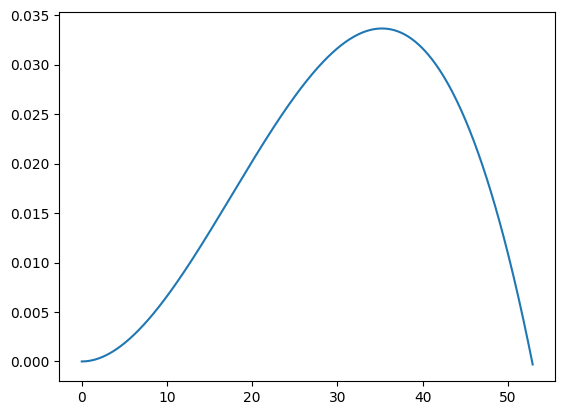

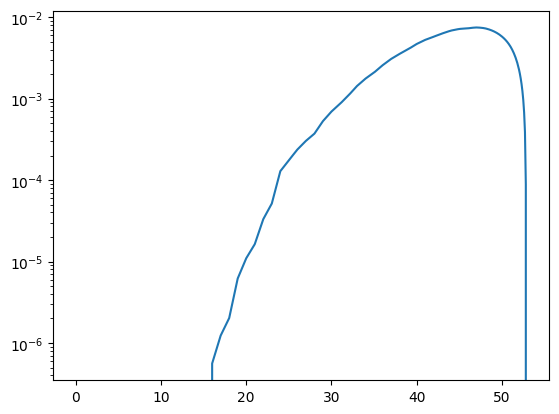

In [113]:
#SNS neutrino spectrum
fig,ax=plt.subplots()
dar_spectrum = 96*np.power(energies_MeV_interp,2) * np.power(m_mu_MeV,-4)  * (m_mu_MeV - 2*energies_MeV_interp)
plt.plot(energies_MeV_interp,dar_spectrum)

fig2,ax2=plt.subplots()
folded_spectrum = np.multiply(xs_cm2_interp,dar_spectrum)
fs = np.where(folded_spectrum > 0, folded_spectrum, 0.0)
probs = fs / fs.sum()
plt.plot(energies_MeV_interp,probs)
plt.yscale("log")

sampled_neutrino_energies_MeV = np.random.choice(energies_MeV_interp, size=nps, p=probs)

plt.show()

In [122]:
#Next, sample excitation probabilities
indices = np.searchsorted(energies_MeV_interp, sampled_neutrino_energies_MeV)

#Create normalized xs matrix
xs_matrix = np.asarray(partial_xs)
xs_matrix = xs_matrix.T
row_sum = xs_matrix.sum(axis=1, keepdims=True)
nonzero_mask = row_sum[:, 0] > 0
xs_probs = np.zeros_like(xs_matrix)
xs_probs[nonzero_mask] = xs_matrix[nonzero_mask] / row_sum[nonzero_mask]

sampled_excitation_indices = []
for idx in indices:
  probs = xs_probs[idx]
  excitation_index = np.random.choice(len(probs),p=probs)
  print(energies_MeV_interp[idx],excitation_index)


49.800000000000004 7
51.7 33
37.2 2
45.800000000000004 7
28.6 2
49.7 11
33.800000000000004 2
50.0 11
51.0 25
52.0 7
37.1 2
42.6 2
46.400000000000006 29
47.900000000000006 11
30.900000000000002 10
49.5 33
37.800000000000004 7
32.2 26
36.4 11
41.6 7
35.2 2
44.900000000000006 11
51.400000000000006 7
31.700000000000003 13
40.400000000000006 33
35.0 11
31.6 2
41.6 2
35.2 11
51.300000000000004 2
40.300000000000004 2
36.6 1
44.900000000000006 26
41.900000000000006 1
44.0 13
34.2 11
46.5 7
40.2 2
48.7 11
50.0 13
39.800000000000004 13
40.1 11
41.900000000000006 6
42.0 26
40.6 1
44.300000000000004 9
48.0 13
49.800000000000004 32
43.800000000000004 27
45.6 11
44.300000000000004 11
32.1 2
48.0 11
45.6 11
51.7 16
49.5 19
41.2 2
47.7 2
47.0 32
37.4 11
47.7 16
44.1 2
36.9 13
40.800000000000004 2
41.5 2
38.6 11
49.2 11
37.7 2
47.6 33
40.0 11
38.6 13
44.0 7
42.300000000000004 2
43.1 13
49.900000000000006 33
40.0 11
52.400000000000006 21
35.0 11
42.7 2
45.900000000000006 7
42.2 2
28.900000000000002 11
4